In [ ]:
# COMPREHENSIVE ANOMALY DETECTION WITH FEATURE EXTRACTION
# Dataset: Metaverse Financial Transactions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

2025-11-02 13:43:38.869653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762091019.142412      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762091019.220884      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# 1. LOAD AND PREPROCESS DATA

# Load the dataset
df = pd.read_csv('/kaggle/input/metaverse-financial-transactions-dataset/metaverse_transactions_dataset.csv')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (78600, 14)

First few rows:
             timestamp  hour_of_day  \
0  2022-04-11 12:47:27           12   
1  2022-06-14 19:12:46           19   
2  2022-01-18 16:26:59           16   
3  2022-06-15 09:20:04            9   
4  2022-02-18 14:35:30           14   

                              sending_address  \
0  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
1  0xd6e251c23cbf52dbd472f079147873e655d8096f   
2  0x2e0925b922fed01f6a85d213ae2718f54b8ca305   
3  0x93efefc25fcaf31d7695f28018d7a11ece55457f   
4  0xad3b8de45d63f5cce28aef9a82cf30c397c6ceb9   

                            receiving_address      amount transaction_type  \
0  0x39f82e1c09bc6d7baccc1e79e5621ff812f50572  796.949206         transfer   
1  0x51e8fbe24f124e0e30a614e14401b9bbfed5384c    0.010000         purchase   
2  0x52c7911879f783d590af45bda0c0ef2b8536706f  778.197390         purchase   
3  0x8ac3b7bd531b3a833032f07d4e47c7af6ea7bace  300.838358         transfer   
4  0x6fdc047c2391615b3facd79b4588c7e

In [ ]:
# 2. FEATURE ENGINEERING

def engineer_features(df):
    """
    Create advanced features from the financial transactions dataset
    """
    df_processed = df.copy()
    
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if col != 'Transaction_ID' and col in df_processed.columns:  # Skip ID column
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
    
    # Create time-based features if timestamp exists
    if 'Timestamp' in df_processed.columns:
        df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])
        df_processed['Hour'] = df_processed['Timestamp'].dt.hour
        df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
        df_processed['Month'] = df_processed['Timestamp'].dt.month
        df_processed = df_processed.drop('Timestamp', axis=1)
    
    # Create aggregation features if Amount exists
    if 'Amount' in df_processed.columns:
        # Log transformation
        df_processed['Amount_Log'] = np.log1p(df_processed['Amount'])
        
        # Statistical features by user (if User_ID exists)
        if 'Sending_Address' in df_processed.columns:
            user_stats = df_processed.groupby('Sending_Address')['Amount'].agg([
                ('Amount_Mean', 'mean'),
                ('Amount_Std', 'std'),
                ('Amount_Max', 'max'),
                ('Amount_Min', 'min')
            ]).reset_index()
            df_processed = df_processed.merge(user_stats, on='Sending_Address', how='left')
    
    # Drop ID columns and non-numeric columns
    id_cols = [col for col in df_processed.columns if 'ID' in col or 'Address' in col]
    df_processed = df_processed.drop(columns=id_cols, errors='ignore')
    
    # Fill NaN values
    df_processed = df_processed.fillna(df_processed.mean())
    
    return df_processed, label_encoders

In [4]:
# Apply feature engineering
df_processed, label_encoders = engineer_features(df)
print("\nProcessed Dataset Shape:", df_processed.shape)
print("\nFeature Names:", df_processed.columns.tolist())


Processed Dataset Shape: (78600, 14)

Feature Names: ['timestamp', 'hour_of_day', 'sending_address', 'receiving_address', 'amount', 'transaction_type', 'location_region', 'ip_prefix', 'login_frequency', 'session_duration', 'purchase_pattern', 'age_group', 'risk_score', 'anomaly']


In [ ]:
# 3. PREPARE DATA FOR ANOMALY DETECTION

# Assuming 'Anomaly' or 'Label' column exists (0 = normal, 1 = anomaly)
# If not, you'll need to create synthetic labels or use unsupervised approach only

y = df_processed['anomaly'].values
y = np.where(y == 1, -1, 1)  # Convert to -1 (anomaly), 1 (normal)
X = df_processed.drop('anomaly', axis=1).values

# if 'anomaly' in df_processed.columns:
#     y = df_processed['Anomaly'].values
#     y = np.where(y == 1, -1, 1)  # Convert to -1 (anomaly), 1 (normal)
#     X = df_processed.drop('Anomaly', axis=1).values
# elif 'Label' in df_processed.columns:
#     y = df_processed['Label'].values
#     y = np.where(y == 1, -1, 1)
#     X = df_processed.drop('Label', axis=1).values
# else:
#     # Use all columns as features (unsupervised only)
#     X = df_processed.values
#     y = None
#     print("\nNo label column found. Running unsupervised methods only.")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (if labels exist)
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )
else:
    X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
    y_train, y_test = None, None

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (62880, 13)
Test set size: (15720, 13)


In [ ]:
# 4. ADVANCED FEATURE EXTRACTION WITH AUTOENCODER

def build_autoencoder(input_dim, encoding_dim=16):
    """
    Build a deep autoencoder for feature extraction
    """
    # Encoder
    encoder_input = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(encoder_input)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu', name='encoding')(encoded)
    
    # Decoder
    decoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation=None)(decoded)
    
    # Autoencoder model
    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Encoder model (for feature extraction)
    encoder = models.Model(encoder_input, encoded)
    
    return autoencoder, encoder

In [7]:
# Train autoencoder
print("\n" + "="*80)
print("TRAINING AUTOENCODER FOR FEATURE EXTRACTION")
print("="*80)

input_dim = X_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim=16)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=0
)

# Extract features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Encoded feature dimension: {X_train_encoded.shape[1]}")


TRAINING AUTOENCODER FOR FEATURE EXTRACTION


2025-11-02 13:43:52.767392: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 2s 742us/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
Original feature dimension: 13
Encoded feature dimension: 16


In [ ]:
# 5. ANOMALY DETECTION METHODS

results = {
    'Method': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Supervision': []
}

def evaluate_method(y_true, y_pred, method_name, supervision_type, results):
    """Helper function to evaluate and store results"""
    if y_true is not None:
        precision = precision_score(y_true, y_pred, pos_label=-1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=-1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=-1, zero_division=0)
        
        results['Method'].append(method_name)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)
        results['Supervision'].append(supervision_type)
        
        print(f"\n{method_name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        return results

print("\n" + "="*80)
print("RUNNING ANOMALY DETECTION METHODS")
print("="*80)

# Use encoded features for better results
X_train_final = X_train_encoded
X_test_final = X_test_encoded


RUNNING ANOMALY DETECTION METHODS


In [ ]:
# 1. K-Nearest Neighbors (KNN)

print("\n[1/11] Running KNN...")
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_train_final)
distances, _ = knn.kneighbors(X_test_final)
anomaly_scores = distances.mean(axis=1)
threshold = np.percentile(anomaly_scores, 95)
y_pred_knn = np.where(anomaly_scores > threshold, -1, 1)
results = evaluate_method(y_test, y_pred_knn, "KNN", "Unsupervised", results)


[1/11] Running KNN...

KNN:
  Precision: 0.6209
  Recall: 0.0384
  F1-Score: 0.0724


In [ ]:
# 2. Local Outlier Factor (LOF)

print("\n[2/11] Running LOF...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=False)
y_pred_lof = lof.fit_predict(X_test_final)
results = evaluate_method(y_test, y_pred_lof, "Local Outlier Factor", "Unsupervised", results)


[2/11] Running LOF...

Local Outlier Factor:
  Precision: 0.7163
  Recall: 0.0443
  F1-Score: 0.0835


In [ ]:
# 3. One-Class SVM

print("\n[3/11] Running One-Class SVM...")
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train_final)
y_pred_ocsvm = ocsvm.predict(X_test_final)
results = evaluate_method(y_test, y_pred_ocsvm, "One-Class SVM", "Unsupervised", results)


[3/11] Running One-Class SVM...

One-Class SVM:
  Precision: 0.5101
  Recall: 0.0339
  F1-Score: 0.0635


In [ ]:
# 4. Isolation Forest

print("\n[4/11] Running Isolation Forest...")
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train_final)
y_pred_iso = iso.predict(X_test_final)
results = evaluate_method(y_test, y_pred_iso, "Isolation Forest", "Unsupervised", results)


[4/11] Running Isolation Forest...

Isolation Forest:
  Precision: 0.3387
  Recall: 0.0214
  F1-Score: 0.0403


In [ ]:
# 5. Elliptic Envelope

print("\n[5/11] Running Elliptic Envelope...")
ell = EllipticEnvelope(contamination=0.05, random_state=42)
ell.fit(X_train_final)
y_pred_ell = ell.predict(X_test_final)
results = evaluate_method(y_test, y_pred_ell, "Elliptic Envelope", "Unsupervised", results)


[5/11] Running Elliptic Envelope...

Elliptic Envelope:
  Precision: 0.1171
  Recall: 0.0074
  F1-Score: 0.0139


In [ ]:
# 6. PCA Reconstruction Error

print("\n[6/11] Running PCA...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
reconstruction_error = np.mean((X_test_final - X_test_reconstructed) ** 2, axis=1)
threshold = np.percentile(reconstruction_error, 95)
y_pred_pca = np.where(reconstruction_error > threshold, -1, 1)
results = evaluate_method(y_test, y_pred_pca, "PCA", "Unsupervised", results)


[6/11] Running PCA...

PCA:
  Precision: 0.6590
  Recall: 0.0408
  F1-Score: 0.0768


In [ ]:
# 7. Gaussian Mixture Model (GMM)

print("\n[7/11] Running GMM...")
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train_final)
scores = gmm.score_samples(X_test_final)
threshold = np.percentile(scores, 5)
y_pred_gmm = np.where(scores < threshold, -1, 1)
results = evaluate_method(y_test, y_pred_gmm, "GMM", "Unsupervised", results)


[7/11] Running GMM...

GMM:
  Precision: 0.5293
  Recall: 0.0328
  F1-Score: 0.0617


In [ ]:
# 8. K-Means

print("\n[8/11] Running K-Means...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_train_final)
distances = np.min(np.abs(X_test_final - kmeans.cluster_centers_[kmeans.predict(X_test_final)]), axis=1)
threshold = np.percentile(distances, 95)
y_pred_kmeans = np.where(distances > threshold, -1, 1)
results = evaluate_method(y_test, y_pred_kmeans, "K-Means", "Unsupervised", results)


[8/11] Running K-Means...

K-Means:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


In [ ]:
# 9. DBSCAN

print("\n[9/11] Running DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(X_test_final)
y_pred_dbscan = np.where(labels == -1, -1, 1)
results = evaluate_method(y_test, y_pred_dbscan, "DBSCAN", "Unsupervised", results)


[9/11] Running DBSCAN...

DBSCAN:
  Precision: 0.8078
  Recall: 1.0000
  F1-Score: 0.8937


In [ ]:
# 10. Autoencoder (Reconstruction Error)

print("\n[10/11] Running Autoencoder...")
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)
threshold = np.percentile(reconstruction_error, 95)
y_pred_auto = np.where(reconstruction_error > threshold, -1, 1)
results = evaluate_method(y_test, y_pred_auto, "Autoencoder", "Unsupervised", results)


[10/11] Running Autoencoder...
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step

Autoencoder:
  Precision: 0.5293
  Recall: 0.0328
  F1-Score: 0.0617


In [ ]:
# 11. AdaBoost (Semi-supervised)

if y_train is not None:
    print("\n[11/11] Running AdaBoost...")
    ada = AdaBoostClassifier(n_estimators=100, random_state=42)
    ada.fit(X_train_final, y_train)
    y_pred_ada = ada.predict(X_test_final)
    results = evaluate_method(y_test, y_pred_ada, "AdaBoost", "Semi-supervised", results)


[11/11] Running AdaBoost...

AdaBoost:
  Precision: 0.9759
  Recall: 0.9848
  F1-Score: 0.9803


In [ ]:
# 6. RESULTS SUMMARY

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

# Save results
results_df.to_csv('metaverse_anomaly_detection_results.csv', index=False)
print("\nResults saved to 'metaverse_anomaly_detection_results.csv'")


FINAL RESULTS

               Method  Precision   Recall  F1-Score     Supervision
                 KNN   0.620865 0.038428  0.072377    Unsupervised
Local Outlier Factor   0.716285 0.044334  0.083500    Unsupervised
       One-Class SVM   0.510083 0.033861  0.063506    Unsupervised
    Isolation Forest   0.338730 0.021419  0.040290    Unsupervised
   Elliptic Envelope   0.117061 0.007402  0.013924    Unsupervised
                 PCA   0.659033 0.040791  0.076826    Unsupervised
                 GMM   0.529262 0.032758  0.061698    Unsupervised
             K-Means   0.000000 0.000000  0.000000    Unsupervised
              DBSCAN   0.807824 1.000000  0.893698    Unsupervised
         Autoencoder   0.529262 0.032758  0.061698    Unsupervised
            AdaBoost   0.975888 0.984802  0.980325 Semi-supervised

Results saved to 'metaverse_anomaly_detection_results.csv'


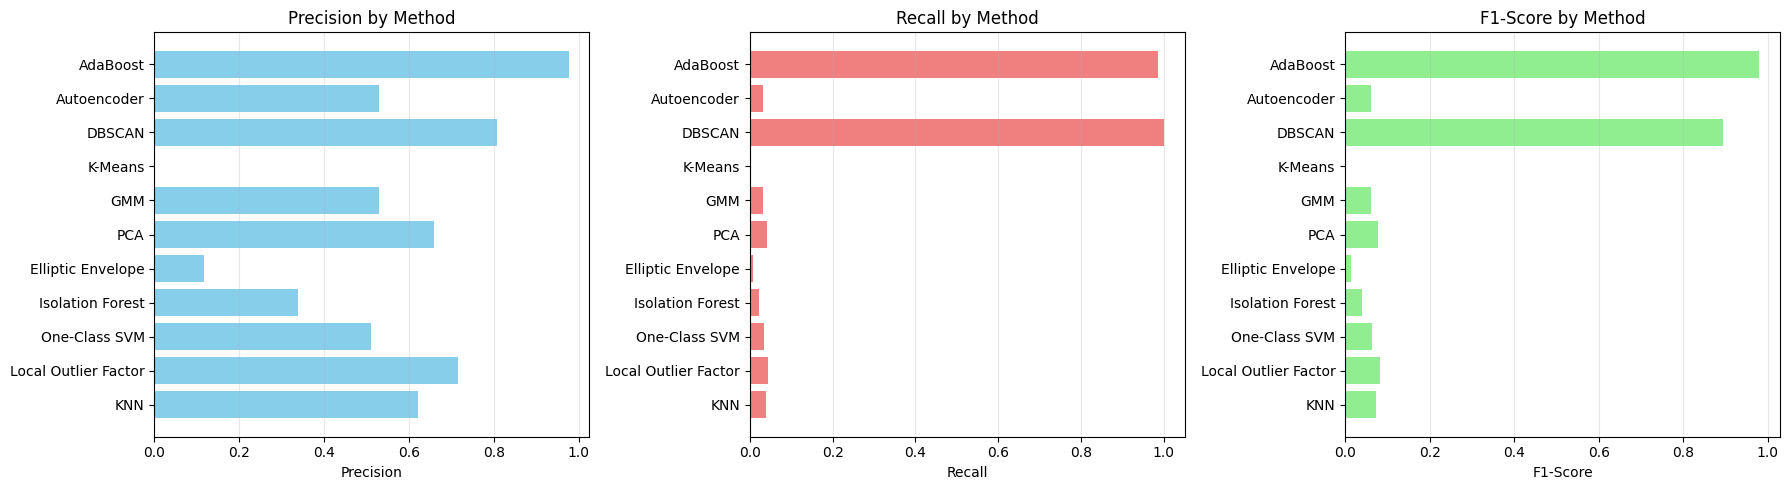


Visualization saved to 'metaverse_anomaly_detection_comparison.png'

ANALYSIS COMPLETE!


In [ ]:
# 7. VISUALIZATION

if len(results_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Precision
    axes[0].barh(results_df['Method'], results_df['Precision'], color='skyblue')
    axes[0].set_xlabel('Precision')
    axes[0].set_title('Precision by Method')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Recall
    axes[1].barh(results_df['Method'], results_df['Recall'], color='lightcoral')
    axes[1].set_xlabel('Recall')
    axes[1].set_title('Recall by Method')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Plot 3: F1-Score
    axes[2].barh(results_df['Method'], results_df['F1-Score'], color='lightgreen')
    axes[2].set_xlabel('F1-Score')
    axes[2].set_title('F1-Score by Method')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('metaverse_anomaly_detection_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved to 'metaverse_anomaly_detection_comparison.png'")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)